In [17]:
import numpy as np
import scipy as sp
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
from time import time as tm

In [2]:
beta = 2/7
gamma = 1/7
Reff = beta/gamma
omega = beta + gamma
r = beta - gamma
rho = omega
ntime = 10000
Tmax = 1000
time = np.linspace(0, Tmax, ntime)
dtime = np.diff(time)[0]
q0 = 0
m0 = 1
m2_0 = 1

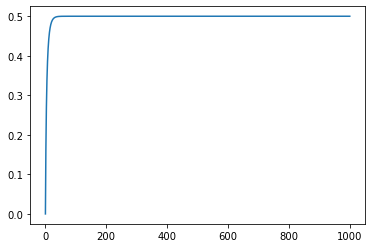

In [3]:
def Offspring(s):
    return 1/(omega) * ((beta * s**2) + gamma)

def q_deriv(u, t):
    return omega * (Offspring(u) - u)



u1 = omega*(1/omega * 2*beta - 1)

u2 = 2*beta 

def mean_deriv(u, t):
    return u1*u

def m2_deriv(u, t):
    return u2 * np.exp(2*u1*t) + u1 * u



q = sp.integrate.odeint(q_deriv, q0, time)

mean = (sp.integrate.odeint(mean_deriv, m0, time))

moment_2 = sp.integrate.odeint(m2_deriv, m2_0, time)

var = moment_2 - mean**2


plt.plot(time, q)
q_grad = np.gradient(q.flatten(), dtime)
tstar_q = np.where(q_grad<=1e-3)[0][0]
# tstar_qs = np.array((np.where(q_grad<=1e-1)[0][0], np.where(q_grad<=1e-2)[0][0], np.where(q_grad<=1e-3)[0][0], np.where(q_grad<=1e-4)[0][0], np.where(q_grad<=1e-5)[0][0]))

var_coeff = np.sqrt(var)/(mean)
var_coeff_grad =  np.gradient(var_coeff.flatten(), dtime)
tstar_var_coeff = np.where(var_coeff_grad<=1e-3)[0][0]
# tstar_var_coeffs = np.array((np.where(var_coeff_grad<=1e-1)[0][0], np.where(var_coeff_grad<=1e-2)[0][0], np.where(var_coeff_grad<=1e-3)[0][0], np.where(var_coeff_grad<=1e-4)[0][0], np.where(var_coeff_grad<=1e-5)[0][0]))



In [5]:
cmap = sns.color_palette("Set2")
cmap[0]

(0.4, 0.7607843137254902, 0.6470588235294118)

/var/folders/79/4z64_xmd40z0hjlyywtt5xfm0000gn/T/ipykernel_21258/1158655529.py:4: RuntimeWarning: divide by zero encountered in log
  plt.plot(time, np.log(var ), label = "Variance", color = cmap[2])


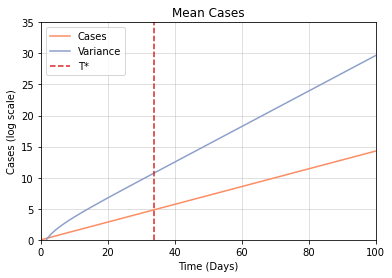

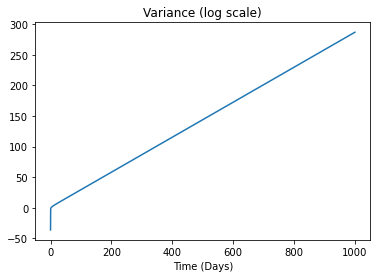

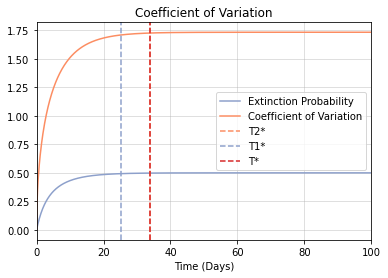

In [6]:

plt.figure(1)
plt.grid(alpha = 0.5)
plt.plot(time, np.log(mean), label = "Cases", color = cmap[1])
plt.plot(time, np.log(var ), label = "Variance", color = cmap[2])
plt.axvline(time[np.max((tstar_q, tstar_var_coeff))], color = 'tab:red', linestyle = '--', label = "T*")
plt.title("Mean Cases")
plt.xlim([0, 100])
plt.ylim([0, 35])
plt.xlabel("Time (Days)")
plt.ylabel("Cases (log scale)")
plt.legend()
# plt.savefig("mean_var_R=" + str(int(Reff)) + ".pdf")



plt.figure(2)
plt.plot(time, np.log(var + np.finfo(float).eps))
plt.title("Variance (log scale)")
plt.xlabel("Time (Days)")



plt.figure(3)
plt.plot(time, q, label = "Extinction Probability", color = cmap[2])
plt.plot(time, var_coeff, label = "Coefficient of Variation", color = cmap[1])
plt.grid(alpha = 0.5)
plt.axvline(time[tstar_var_coeff], color = cmap[1], linestyle = '--', label = "T2*")
plt.axvline(time[tstar_q], color = cmap[2], linestyle = '--', label = "T1*")
plt.axvline(time[np.max((tstar_q, tstar_var_coeff))] , color = 'tab:red', linestyle = '--', label = "T*")
plt.title("Coefficient of Variation")
plt.xlabel("Time (Days)")
plt.xlim([0, 100])
plt.legend()
# plt.savefig("Tstar_choice_R=" + str(int(Reff)) + ".pdf")

In [78]:
u1 = beta - gamma
omega = beta + gamma



epsilons = 1e-5 * np.array((0.5e4, 1e3, 0.5e3, 1e2, 0.5e2, 1e1, 0.5e1, 1, 0.5))
tstar_qs_list = [np.where(q_grad<=thresh)[0][0] for thresh in epsilons]
tstar_qs = np.array(tstar_qs_list)
tstar_var_coeffs_list = [np.where(var_coeff_grad<=thresh)[0][0] for thresh in epsilons]
tstar_var_coeffs = np.array(tstar_var_coeffs_list)
tstar_idxs = np.maximum(tstar_qs, tstar_var_coeffs)


stop_cases = mean[tstar_idxs]#/q[tstar_idxs]
stop_cases_sqrt = [np.sqrt(im) for im in stop_cases]
cols = [str(int(label)) for label in stop_cases]
cols_sqrt = [str(int(label)) for label in stop_cases_sqrt]


stop_cases_idx = 7
st_idx = stop_cases_idx
tstar_idx = tstar_idxs[stop_cases_idx]
Imax_feller = stop_cases[stop_cases_idx][0]
Imax = np.sqrt(Imax_feller)

In [79]:
Imax_feller

12450.48116625978

In [80]:
def gp_mu(u, t):
    return (u1)/2 * u

def gp_sigma(u, t):
    return np.sqrt(omega)/2

def gp_var(u, t):
    return (u1)*u + (omega/4)

def dW(t):
    return np.random.normal(loc = 0.0, scale = np.sqrt(t))


# Unapproximated Feller Diffusion

def feller_mu(u, t):
    return (beta - gamma) * u 

def feller_sigma(u, t):
    return np.sqrt(omega * u)

def feller_sigma_theory(u, t):
    return 2*u1*u + omega


def EulerMaruyama(drift, sigma, dW, t0, y0, dt, stop = None, num_its = len(time)):
    t = t0
    y = np.zeros(num_its)
    y[0] = y0
    stop_times = []
    checks = 0
    for i in range(1, num_its):
        yn = y[i-1] + drift(y[i-1], t)*dt + sigma(y[i-1],t) * dW(dt)
        if yn >0:
            y[i] = yn
        else:
            y[i] = 0
            stop_times = [np.nan for i in range(len(stop))]
            break
        
        if stop is not None:
            if yn >= stop[checks]:
                y[i:] = yn
                stop_time = t - dt
                stop_times.append(stop_time)
                checks +=1
                if checks == len(stop):
                    break
            
            
        
        t += dt
    if stop is not None:       
        if len(stop_times)<len(stop):
            stop_times_append = len(stop) - len(stop_times)
            stop_times_nans = [np.nan for i in range(stop_times_append)]
            stop_times += stop_times_nans
        
    return stop_times, y




y0 = 1
t0 = 0
dt = np.diff(time)[0]


nsims = 100000
np.random.seed(123)
stop_times = np.zeros((nsims, len(stop_cases)))
stop_times1 = np.zeros((nsims, len(stop_cases)))
for i in tqdm(range(nsims)):
    stop_time1, feller_sim1 = EulerMaruyama(feller_mu, feller_sigma, dW, t0, y0, dt, stop = [Imax_feller], num_its = len(time))
    stop_times1[i, :] = stop_time1
#     if i%(int(nsims/10)) == 0:
#         plt.plot(time, feller_sim, alpha = 0.8)
    
stop_times_df = pd.DataFrame(stop_times, columns = cols_sqrt)
# stop_times_df = stop_times_df[stop_times_df["T*"] != 0]
 
stop_times_df1 = pd.DataFrame(stop_times1, columns = cols)
# stop_times_df1 = stop_times_df1[stop_times_df1["T*"] != 0]





100%|██████████████████████████████████| 100000/100000 [02:57<00:00, 564.04it/s]


In [81]:
def gillespie(beta, gamma, y0, Tmax = Tmax, nevents = int(1e6), stop = [Imax_feller]):
    omega = beta + gamma
    t = 0
    rands = np.random.random(2*nevents).reshape((nevents, 2))
    cases = np.nan * np.ones(nevents)
    cases[0] = y0
    checks = 0
    stop_times = []
    for e in range(1, nevents):
        rate_vec = np.array((beta*cases[e-1], gamma*cases[e-1]))
        rate_sum = np.sum(rate_vec)

        rate_cumsum = np.cumsum(rate_vec)
        dt = -np.log(rands[e, 0])/rate_sum
        t += dt
        event_rand = rate_sum * rands[e, 1]
        event = np.where(rate_cumsum > event_rand)[0][0]
        if event ==0:
            cases[e] = cases[e-1] + 1
        elif event == 1:
            cases[e] = cases[e-1] - 1
        if cases[e] >= stop[checks]:
            cases[(e+1):] = cases[e]
            stop_times.append(t)
            checks +=1
            if checks == len(stop):
                break
        elif cases[e] == 0:
            stop_times = [np.nan for i in range(len(stop))]
            cases[(e+1):] = 0
            break
    if len(stop_times)<len(stop):
        stop_times_append = len(stop) - len(stop_times)
        stop_times_nans = [np.nan for i in range(stop_times_append)]
        stop_times += stop_times_nans
    return stop_times, cases
nsims = 100000
stop_times2 = np.zeros((nsims, len(stop_cases)))
np.random.seed(123)
st1 = tm()
for i in tqdm(range(nsims)):
    stop_time2, gillespie_sim = gillespie(beta, gamma, 1, stop = [Imax_feller])
    stop_times2[i, :] = stop_time2
        
print(str(nsims) + " runs of the Gillespie algorithm takes " + str(tm() - st1) + " seconds.")        

stop_times_df2  = pd.DataFrame(stop_times2, columns = cols)
stop_times_df2[cols] = stop_times_df2[cols].replace({0:np.nan})
stop_times_df2

100%|█████████████████████████████████| 100000/100000 [5:32:03<00:00,  5.02it/s]

100000 runs of the Gillespie algorithm takes 19923.19990181923 seconds.


,3,12,25,125,248,1247,2477,12450,24718
0,65.558041,65.558041,65.558041,65.558041,65.558041,65.558041,65.558041,65.558041,65.558041
1,75.278126,75.278126,75.278126,75.278126,75.278126,75.278126,75.278126,75.278126,75.278126
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,63.996354,63.996354,63.996354,63.996354,63.996354,63.996354,63.996354,63.996354,63.996354
...,...,...,...,...,...,...,...,...,...
99995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


  0%|                                                 | 0/10000 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1953: RuntimeWarning: divide by zero encountered in true_divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
100%|███████████████████████████████████| 10000/10000 [00:08<00:00, 1240.06it/s]


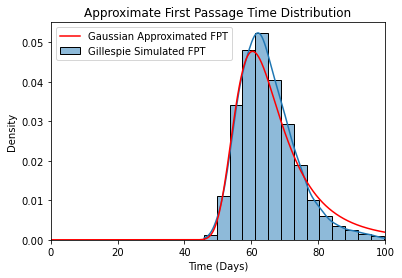

In [77]:
dtime = time[1] - time[0]
sns.color_palette("Accent")
gp_mean_theory = sp.integrate.odeint(gp_mu, y0, time)
gp_var_theory = sp.integrate.odeint(gp_var, 0, time)
cdf = np.zeros_like(time)
for t_idx in tqdm(range(len(time))):
    prob = (1 - sp.stats.norm(gp_mean_theory[t_idx], (gp_var_theory[t_idx])**(1/2)).cdf(stop_cases_sqrt[st_idx]))/(1-sp.stats.norm(gp_mean_theory[t_idx], (gp_var_theory[t_idx])**(1/2)).cdf(0))
    cdf[t_idx] = prob

pdf = np.gradient(cdf, dtime)
pdf[np.isnan(pdf)] = 0
plt.figure(1)
sns.histplot(stop_times_df2[cols[st_idx]], stat = 'density', bins = 20, label = "Gillespie Simulated FPT", kde = True)
plt.plot(time, pdf, color = 'r', label = "Gaussian Approximated FPT")
plt.xlabel("Time (Days)")
plt.xlim([0, 100])
plt.title("Approximate First Passage Time Distribution")
plt.legend()

In [65]:
r = beta - gamma
rho = beta + gamma

gp_mean_theory = sp.integrate.odeint(gp_mu, y0, time)
gp_var_theory = sp.integrate.odeint(gp_var, 0, time)

def chi_sq(u, x, t):
    x_scale = 2*r*x/(((rho/2))*(np.exp(r*t) - 1))
    lamb = 2*r*np.exp(r*t)/((rho/2)*(np.exp(r*t) - 1))
    chi_sq_pdf = r/((rho/2)*(np.exp(r*t) - 1)) * np.sqrt(np.exp(r*t)/x) * np.exp(- 1/2 * (lamb + x_scale)) * sp.special.iv(1, np.sqrt(x_scale*lamb)) / ((1-np.exp(-lamb/2)))

    return chi_sq_pdf

xvec = np.linspace(np.finfo(float).eps, 20000, int(1e5))
xvec_idx = np.min(np.where(xvec>=stop_cases[st_idx])[0])

cdf_chisq = np.zeros_like(time)

for T_idx in tqdm(range(len(time))):
    T = time[T_idx]
    
    chi_sq_integral = sp.integrate.odeint(chi_sq, 0, xvec, args = (T,)).flatten() 

    prob =  (1-(chi_sq_integral[xvec_idx]))
    cdf_chisq[T_idx] = prob


pdf_chisq = np.gradient(cdf_chisq, dtime)






  0%|                                                 | 0/10000 [00:00<?, ?it/s]/var/folders/79/4z64_xmd40z0hjlyywtt5xfm0000gn/T/ipykernel_21258/2815894947.py:8: RuntimeWarning: divide by zero encountered in double_scalars
  x_scale = 2*r*x/(((rho/2))*(np.exp(r*t) - 1))
/var/folders/79/4z64_xmd40z0hjlyywtt5xfm0000gn/T/ipykernel_21258/2815894947.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  lamb = 2*r*np.exp(r*t)/((rho/2)*(np.exp(r*t) - 1))
/var/folders/79/4z64_xmd40z0hjlyywtt5xfm0000gn/T/ipykernel_21258/2815894947.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  chi_sq_pdf = r/((rho/2)*(np.exp(r*t) - 1)) * np.sqrt(np.exp(r*t)/x) * np.exp(- 1/2 * (lamb + x_scale)) * sp.special.iv(1, np.sqrt(x_scale*lamb)) / ((1-np.exp(-lamb/2)))
/var/folders/79/4z64_xmd40z0hjlyywtt5xfm0000gn/T/ipykernel_21258/2815894947.py:10: RuntimeWarning: invalid value encountered in double_scalars
  chi_sq_pdf = r/((rho/2)*(np.exp(r*t) - 1)) * np.sqrt(np.exp(r*t)/x) * np.